**Note to grader:** Each question consists of parts, e.g. Q1(i), Q1(ii), etc. Each part must be first graded  on a 0-4 scale, following the standard NJIT convention (A:4, B+: 3.5, B:3, C+: 2.5, C: 2, D:1, F:0). However, any given item may be worth 4 or 8 points; if an item is worth 8 points, you need to accordingly scale the 0-4 grade.


The total score must be re-scaled to 100. That should apply to all future assignments so that Canvas assigns the same weight on all assignments. 



# <font color = 'green'>   **Assignment 6**


In this assignment we will do some exercises with material from recurrent neural networks and computer vision. 



In [ ]:
!pip install d2l==0.16.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 902 kB/s 
     |████████████████████████████████| 121 kB 47.8 MB/s 
     |████████████████████████████████| 1.6 MB 49.3 MB/s 
     |████████████████████████████████| 83 kB 1.7 MB/s 


In [ ]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch
import torch.utils.benchmark
from torch import nn
from torch.nn import functional as F
from sklearn.preprocessing import StandardScaler

In [ ]:
# Checking if GPU is available
from torch import cuda 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Torchinfo, install if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


# <font color = 'green'>   **Question 1**

<font color = 'green'>  [Chapter 13.12](https://classic.d2l.ai/chapter_computer-vision/neural-style.html) of the previous-version textbook discusses neural style transfer. In the cells below copy the appropriate cells from that notebook and apply it to some images of your choice. Show your work, and post it on the discussion board of the last week of the course. 

## <font color = 'gray'>   
Mount and upload `Style` and `Content` images to load 

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


CPU times: user 245 ms, sys: 35.6 ms, total: 280 ms
Wall time: 2.73 s


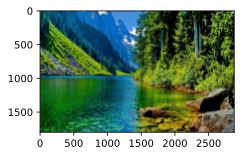

In [ ]:
%%time
d2l.set_figsize()
style_img = d2l.Image.open('/content/gdrive/MyDrive/CS677/nature-images.jpg')
d2l.plt.imshow(style_img);

CPU times: user 23.2 ms, sys: 3.3 ms, total: 26.5 ms
Wall time: 889 ms


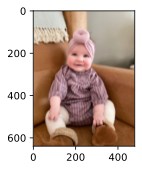

In [ ]:
%%time
d2l.set_figsize()
content_img = d2l.Image.open('/content/gdrive/MyDrive/CS677/ISLA.jpg')
d2l.plt.imshow(content_img);

## <font color = 'gray'> 

Following [Neural Transfer](https://classic.d2l.ai/chapter_computer-vision/neural-style.html#preprocessing-and-postprocessing) instructions provided.

In [ ]:
import torchvision

rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [ ]:
pretrained_net = torchvision.models.vgg19(pretrained=True)
pretrained_net

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## <font color = 'gray'> 

As mentioned in [Secton 7.2](https://classic.d2l.ai/chapter_convolutional-modern/vgg.html#sec-vgg), the VGG network uses 5 convolutional blocks. 

In [ ]:
# In the experiment, we choose the last convolutional layer of the fourth 
# convolutional block as the content layer, and the first convolutional layer 
# of each convolutional block as the style layer. The indices of these layers 
# can be obtained by printing the pretrained_net instance.
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [ ]:
# Using VGG layers, we only need to use all those from the input layer to 
# the content layer or style layer that is closest to the output layer.
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])
net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
# Given the input X, if we invoke the forward propagation net(X), 
# we can only get the output of the last layer.
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [ ]:
# Two functions are defined below: the get_contents function extracts content 
# features from the content image, and the get_styles function extracts style 
# features from the style image.
# Assumes content_img contains your content image.
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y
# Assumes style__img contains your style image.
def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## <font color = "gray">

The two inputs of the squared loss function are both outputs of the content layer computed by the `extract_features` function. Style loss, similar to content loss, also uses the squared loss function to measure the difference in style between the synthesized image and the style image.

`f*squared = 2(eta)-1 = 2p(1|x)-1`

In [ ]:
def content_loss(Y_hat, Y):
    # We detach the target content from the tree used to dynamically compute
    # the gradient: this is a stated value, not a variable. Otherwise the loss
    # will throw an error.
    return torch.square(Y_hat - Y.detach()).mean()

In [ ]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

In [ ]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [ ]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [ ]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # Calculate the content, style, and total variance losses respectively
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # Add up all the losses
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [ ]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [ ]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [ ]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

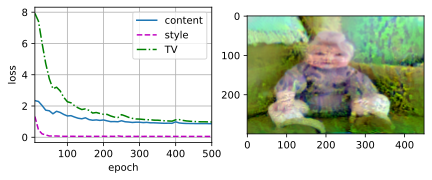

In [ ]:
device, image_shape = d2l.try_gpu(), (300, 450)  # PIL Image (h, w)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

# <font color = 'green'>   **Question 2**

<font color = 'green'> Experiment with the settings of the neural style transfer model from the previous question. What happens if you change the designated 'content' and 'style' layers. Demonstrate your work and provide a thorough description. 
<font color = 'green'>  

In [ ]:
# Moving the content and style layers

style_layers2, content_layers2 = [0, 5, 10, 19, 23], [28]
net2 = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])
net2

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

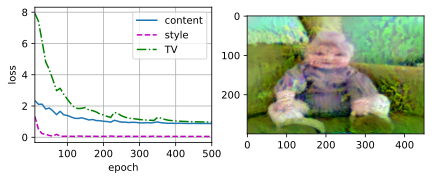

In [ ]:
net2 = net2.to(device)
content_X2, contents_Y2 = get_contents(image_shape, device)
_, styles_Y2 = get_styles(image_shape, device)
output2 = train(content_X2, contents_Y2, styles_Y, device, 0.3, 500, 50)

# <font color = 'green'>   **Question 3**

<font color = 'green'> In [Chapter 8.1](https://colab.research.google.com/drive/1R8w6m60PJkvthrSDv5RQ9U5S9NqslJxj?usp=drive_fs#scrollTo=tg8qVByik774) we saw a task of predicting a simple time series with a standard regression model. Based on that notebook, replace the simple regression model with an RNN architecture using GRU or LSTMS units. Discuss how your model works and its hyperparameters. 

<font color = 'green'> <br> [**Note**: This may take you a little more effort, but it's worth it! This can also serve as a base for the one option of the second mini-project]



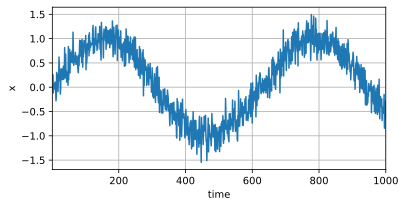

In [ ]:
%matplotlib inline

import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [ ]:
tau = 4
batch_size = 16
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600

# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [ ]:

class TimeSeriesLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(
        input_size=input_size, 
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True,
    )
    self.linear = nn.Linear(hidden_size, 1)
  
  def forward(self, x):
    batch_size = x.shape[0]

    h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size,requires_grad=True)
    c0 = torch.zeros(self.num_layers, batch_size,self.hidden_size,requires_grad=True)

    _, (hn, cn) = self.lstm(x.view(batch_size,1,-1), (h0,c0))
    
    return self.linear(hn.view(-1,self.hidden_size))
    

In [ ]:
# Function for initializing the weights of the network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# A simple LSTM
hidden_size = 10
num_layers = 1
input_size = 4

def new_net():
    new_net = TimeSeriesLSTM(input_size, hidden_size, num_layers)
    new_net.apply(init_weights)
    return new_net

# Note: `MSELoss` computes squared error without the 1/2 factor
loss = nn.MSELoss(reduction='none')

In [ ]:
def train(new_net, train_iter, loss, epochs, lr):
    optimizer = torch.optim.Adam(new_net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(new_net(X), y)
            l.sum().backward()
            optimizer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(new_net, train_iter, loss):f}')

final = new_net()

train(final, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.062348
epoch 2, loss: 0.052355
epoch 3, loss: 0.052471
epoch 4, loss: 0.052493
epoch 5, loss: 0.053511


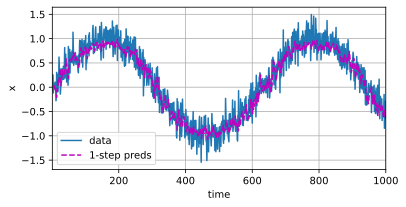

In [ ]:
onestep_preds = final(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

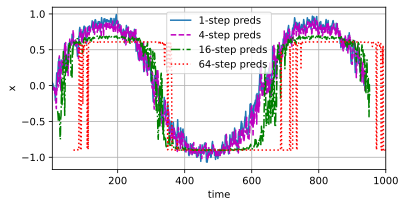

In [ ]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = final(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))
